# Computer Vision Assignment 2: Image Classification with Convolutional Neural Networks

## PART 1 - Modeling and Training a CNN classifier from Scratch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset path
dataset_root = "food11"

# Load datasets
train_dataset = ImageFolder(os.path.join(dataset_root, "train"), transform=train_transform)
val_dataset = ImageFolder(os.path.join(dataset_root, "validation"), transform=val_test_transform)
test_dataset = ImageFolder(os.path.join(dataset_root, "test"), transform=val_test_transform)

# Print number of samples per set
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Using device: cuda
Train samples: 2200
Validation samples: 275
Test samples: 275
Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


In [ ]:

def train_and_evaluate_model(model_class, train_dataset, val_dataset, class_names,
                             batch_sizes, learning_rates, num_epochs, device,
                             title="Model"):

    best_model_data = None
    best_val_acc = 0.0

    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"\nTraining with batch size = {batch_size}, learning rate = {lr}")

            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            
            model = model_class(num_classes=len(class_names)).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_losses = []
            val_losses = []
            train_accuracies = []
            val_accuracies = []

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_acc = correct / total
                train_losses.append(running_loss / len(train_loader))
                train_accuracies.append(train_acc)

                # Validation
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_acc = correct / total
                val_losses.append(val_loss / len(val_loader))
                val_accuracies.append(val_acc)

                print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

            # Plot both loss and accuracy graphs
            fig, axs = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f"{title} | Batch Size={batch_size}, LR={lr} | Final Val Acc:={val_accuracies[-1]:.4f}")

            # Loss plot
            axs[0].plot(train_losses, label="Train Loss", color='blue')
            axs[0].plot(val_losses, label="Val Loss", color='orange')
            axs[0].set_title("Loss Over Epochs")
            axs[0].set_xlabel("Epoch")
            axs[0].set_ylabel("Loss")
            axs[0].legend()

            # Accuracy plot
            axs[1].plot(train_accuracies, label="Train Accuracy", color='green')
            axs[1].plot(val_accuracies, label="Val Accuracy", color='red')
            axs[1].set_title("Accuracy Over Epochs")
            axs[1].set_xlabel("Epoch")
            axs[1].set_ylabel("Accuracy")
            axs[1].legend()

            plt.tight_layout(rect=[0, 0, 1, 0.95])  
            plt.show()

            # Save the best model with the best final val accuracy
            if val_accuracies[-1] > best_val_acc:
                best_val_acc = val_accuracies[-1]
                best_model_data = {
                    "model": model,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "train_accuracies": train_accuracies,
                    "val_accuracies": val_accuracies,
                    "final_accuracy": val_accuracies[-1],
                    "batch_size": batch_size,
                    "learning_rate": lr
                }

    return best_model_data


In [ ]:
def train_and_evaluate_model_with_dropout(model_class, train_dataset, val_dataset, class_names,
                                          batch_size, learning_rate, num_epochs, device,
                                          dropout_values, title="Model"):
    best_model_data = None
    best_val_acc = 0.0

    for dropout_rate in dropout_values:
        print(f"\nTraining with dropout = {dropout_rate}")

        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = model_class(num_classes=len(class_names), use_dropout=True, dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = correct / total
            train_losses.append(running_loss / len(train_loader))
            train_accuracies.append(train_acc)

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = correct / total
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        # Plot both loss and accuracy graphs
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f"{title} | Batch Size={batch_size}, LR={learning_rate} | Dropout={dropout_rate} | Final Val Acc={val_accuracies[-1]:.4f}")

        # Loss plot
        axs[0].plot(train_losses, label="Train Loss", color='blue')
        axs[0].plot(val_losses, label="Val Loss", color='orange')
        axs[0].set_title("Loss Over Epochs")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        # Accuracy plot
        axs[1].plot(train_accuracies, label="Train Accuracy", color='green')
        axs[1].plot(val_accuracies, label="Val Accuracy", color='red')
        axs[1].set_title("Accuracy Over Epochs")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        # Save the best model with the best final val accuracy
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            best_model_data = {
                "model": model,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies,
                "final_accuracy": val_accuracies[-1],
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "dropout_rate": dropout_rate
            }

    return best_model_data

In [73]:
def evaluate_model_on_test(model, test_dataset, device, batch_size=64):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [74]:
def plot_confusion_matrix(model_data, val_dataset, class_names, device, title="Confusion Matrix"):
    model = model_data["model"]
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    ax.set_title(title)
    plt.show()

In [ ]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11, use_dropout=False, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128 → 64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 → 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 → 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 → 8

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Classifier with optional dropout
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU()
        ]
        
        if use_dropout:
            classifier_layers.append(nn.Dropout(dropout_rate))
        classifier_layers.append(nn.Linear(512, num_classes))

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



Training with batch size = 64, learning rate = 0.001
Epoch [1/50] - Train Acc: 0.1250 - Val Acc: 0.1491
Epoch [2/50] - Train Acc: 0.1841 - Val Acc: 0.1818
Epoch [3/50] - Train Acc: 0.2136 - Val Acc: 0.2182
Epoch [4/50] - Train Acc: 0.2323 - Val Acc: 0.2400
Epoch [5/50] - Train Acc: 0.2591 - Val Acc: 0.3527
Epoch [6/50] - Train Acc: 0.2909 - Val Acc: 0.3091
Epoch [7/50] - Train Acc: 0.2868 - Val Acc: 0.3091
Epoch [8/50] - Train Acc: 0.3118 - Val Acc: 0.3273
Epoch [9/50] - Train Acc: 0.3291 - Val Acc: 0.3600
Epoch [10/50] - Train Acc: 0.3555 - Val Acc: 0.4218
Epoch [11/50] - Train Acc: 0.3618 - Val Acc: 0.3891
Epoch [12/50] - Train Acc: 0.3859 - Val Acc: 0.3964
Epoch [13/50] - Train Acc: 0.4091 - Val Acc: 0.3891
Epoch [14/50] - Train Acc: 0.4032 - Val Acc: 0.3855
Epoch [15/50] - Train Acc: 0.4205 - Val Acc: 0.4364
Epoch [16/50] - Train Acc: 0.4427 - Val Acc: 0.4436
Epoch [17/50] - Train Acc: 0.4418 - Val Acc: 0.4255
Epoch [18/50] - Train Acc: 0.4705 - Val Acc: 0.5127
Epoch [19/50] - Tra

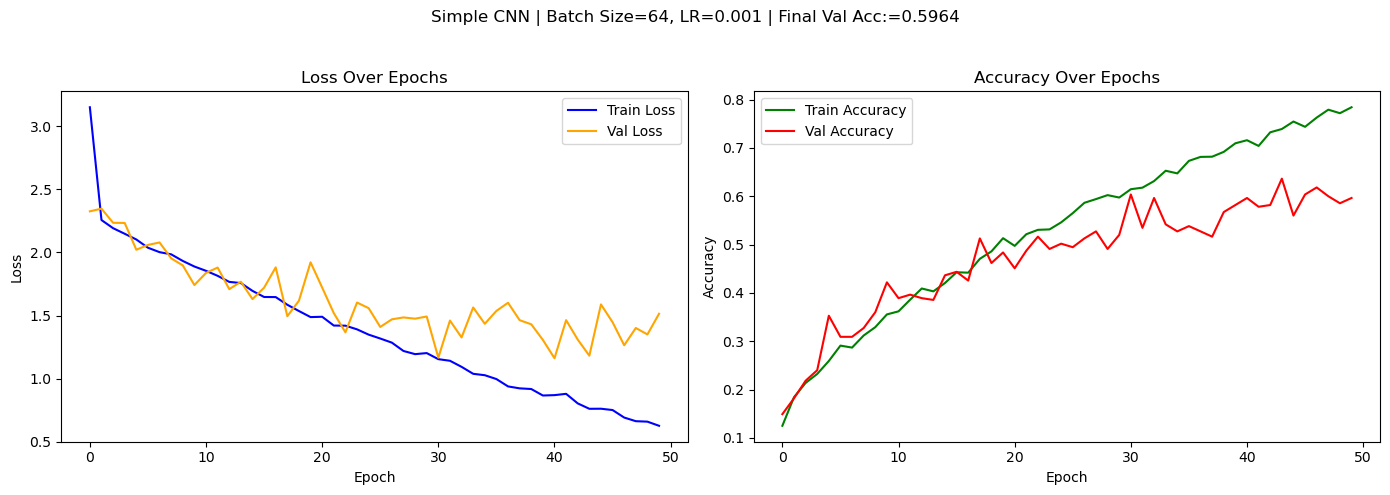


Training with batch size = 64, learning rate = 0.0005
Epoch [1/50] - Train Acc: 0.1668 - Val Acc: 0.1927
Epoch [2/50] - Train Acc: 0.2605 - Val Acc: 0.2945
Epoch [3/50] - Train Acc: 0.3036 - Val Acc: 0.3382
Epoch [4/50] - Train Acc: 0.3300 - Val Acc: 0.2218
Epoch [5/50] - Train Acc: 0.3564 - Val Acc: 0.2582
Epoch [6/50] - Train Acc: 0.3682 - Val Acc: 0.3964
Epoch [7/50] - Train Acc: 0.3891 - Val Acc: 0.4109
Epoch [8/50] - Train Acc: 0.4359 - Val Acc: 0.5055
Epoch [9/50] - Train Acc: 0.4559 - Val Acc: 0.4291
Epoch [10/50] - Train Acc: 0.4750 - Val Acc: 0.4545
Epoch [11/50] - Train Acc: 0.4859 - Val Acc: 0.4764
Epoch [12/50] - Train Acc: 0.5150 - Val Acc: 0.5055
Epoch [13/50] - Train Acc: 0.5132 - Val Acc: 0.4982
Epoch [14/50] - Train Acc: 0.5355 - Val Acc: 0.5055
Epoch [15/50] - Train Acc: 0.5509 - Val Acc: 0.4691
Epoch [16/50] - Train Acc: 0.5809 - Val Acc: 0.5382
Epoch [17/50] - Train Acc: 0.5764 - Val Acc: 0.5273
Epoch [18/50] - Train Acc: 0.6077 - Val Acc: 0.5236
Epoch [19/50] - Tr

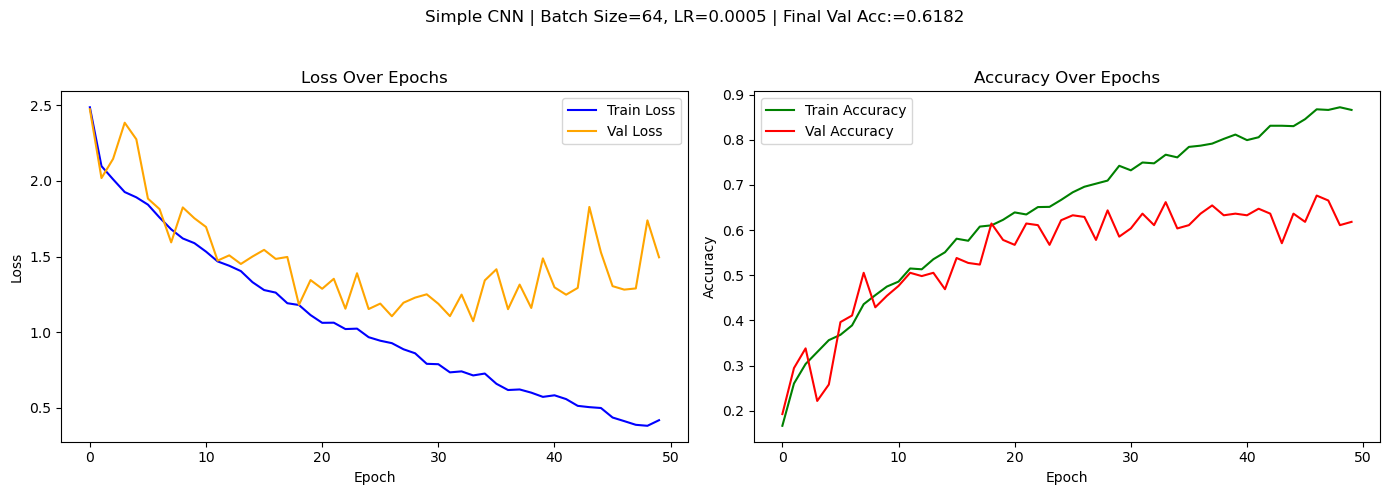


Training with batch size = 64, learning rate = 0.0001
Epoch [1/50] - Train Acc: 0.1759 - Val Acc: 0.1418
Epoch [2/50] - Train Acc: 0.2709 - Val Acc: 0.3273
Epoch [3/50] - Train Acc: 0.3386 - Val Acc: 0.4218
Epoch [4/50] - Train Acc: 0.3641 - Val Acc: 0.3636
Epoch [5/50] - Train Acc: 0.3923 - Val Acc: 0.4327
Epoch [6/50] - Train Acc: 0.4282 - Val Acc: 0.3818
Epoch [7/50] - Train Acc: 0.4541 - Val Acc: 0.4545
Epoch [8/50] - Train Acc: 0.4632 - Val Acc: 0.4509
Epoch [9/50] - Train Acc: 0.4682 - Val Acc: 0.4982
Epoch [10/50] - Train Acc: 0.5009 - Val Acc: 0.4691
Epoch [11/50] - Train Acc: 0.5150 - Val Acc: 0.5018
Epoch [12/50] - Train Acc: 0.5141 - Val Acc: 0.4436
Epoch [13/50] - Train Acc: 0.5441 - Val Acc: 0.4545
Epoch [14/50] - Train Acc: 0.5455 - Val Acc: 0.5527
Epoch [15/50] - Train Acc: 0.5750 - Val Acc: 0.4836
Epoch [16/50] - Train Acc: 0.5836 - Val Acc: 0.4909
Epoch [17/50] - Train Acc: 0.5827 - Val Acc: 0.5382
Epoch [18/50] - Train Acc: 0.5995 - Val Acc: 0.5673
Epoch [19/50] - Tr

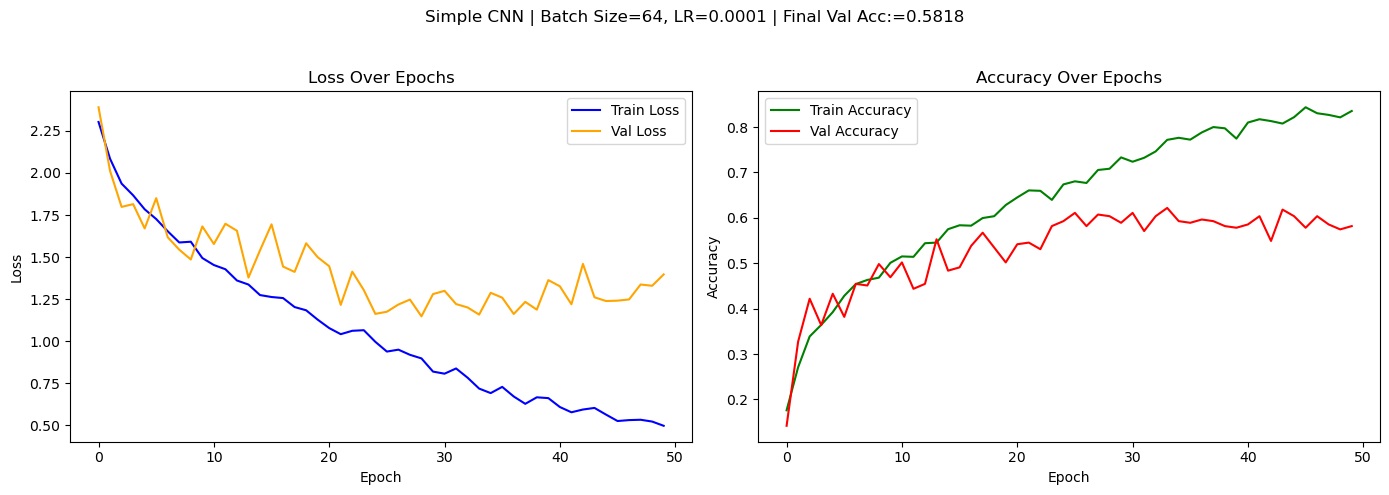


Training with batch size = 128, learning rate = 0.001
Epoch [1/50] - Train Acc: 0.1086 - Val Acc: 0.1127
Epoch [2/50] - Train Acc: 0.1473 - Val Acc: 0.2000
Epoch [3/50] - Train Acc: 0.1868 - Val Acc: 0.2182
Epoch [4/50] - Train Acc: 0.2205 - Val Acc: 0.2473
Epoch [5/50] - Train Acc: 0.2468 - Val Acc: 0.2327
Epoch [6/50] - Train Acc: 0.2736 - Val Acc: 0.2982
Epoch [7/50] - Train Acc: 0.2677 - Val Acc: 0.3055
Epoch [8/50] - Train Acc: 0.3064 - Val Acc: 0.3564
Epoch [9/50] - Train Acc: 0.3077 - Val Acc: 0.3455
Epoch [10/50] - Train Acc: 0.3277 - Val Acc: 0.3345
Epoch [11/50] - Train Acc: 0.3568 - Val Acc: 0.3527
Epoch [12/50] - Train Acc: 0.3582 - Val Acc: 0.2909
Epoch [13/50] - Train Acc: 0.3627 - Val Acc: 0.4073
Epoch [14/50] - Train Acc: 0.3968 - Val Acc: 0.3127
Epoch [15/50] - Train Acc: 0.3977 - Val Acc: 0.3636
Epoch [16/50] - Train Acc: 0.4227 - Val Acc: 0.3673
Epoch [17/50] - Train Acc: 0.4259 - Val Acc: 0.4727
Epoch [18/50] - Train Acc: 0.4373 - Val Acc: 0.4691
Epoch [19/50] - Tr

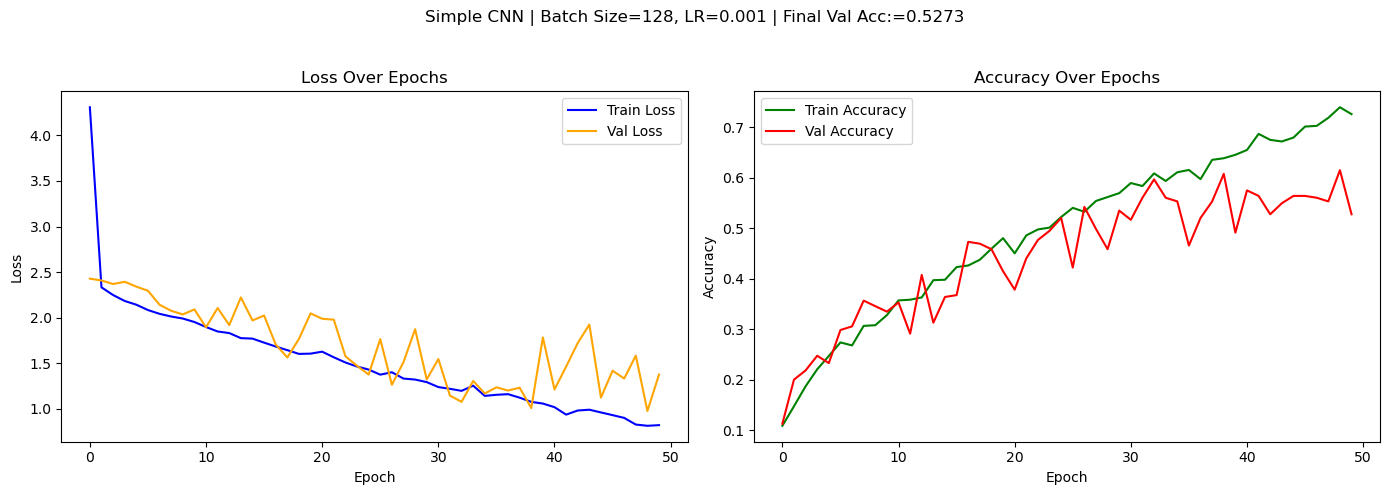


Training with batch size = 128, learning rate = 0.0005
Epoch [1/50] - Train Acc: 0.1482 - Val Acc: 0.1273
Epoch [2/50] - Train Acc: 0.2409 - Val Acc: 0.2255
Epoch [3/50] - Train Acc: 0.2627 - Val Acc: 0.3127
Epoch [4/50] - Train Acc: 0.3150 - Val Acc: 0.2473
Epoch [5/50] - Train Acc: 0.3418 - Val Acc: 0.2582
Epoch [6/50] - Train Acc: 0.3536 - Val Acc: 0.3382
Epoch [7/50] - Train Acc: 0.3805 - Val Acc: 0.3745
Epoch [8/50] - Train Acc: 0.3886 - Val Acc: 0.4073
Epoch [9/50] - Train Acc: 0.4223 - Val Acc: 0.4218
Epoch [10/50] - Train Acc: 0.4309 - Val Acc: 0.4291
Epoch [11/50] - Train Acc: 0.4814 - Val Acc: 0.4945
Epoch [12/50] - Train Acc: 0.4705 - Val Acc: 0.2909
Epoch [13/50] - Train Acc: 0.4727 - Val Acc: 0.4836
Epoch [14/50] - Train Acc: 0.5145 - Val Acc: 0.4545
Epoch [15/50] - Train Acc: 0.5286 - Val Acc: 0.4945
Epoch [16/50] - Train Acc: 0.5277 - Val Acc: 0.4509
Epoch [17/50] - Train Acc: 0.5564 - Val Acc: 0.5018
Epoch [18/50] - Train Acc: 0.5414 - Val Acc: 0.4618
Epoch [19/50] - T

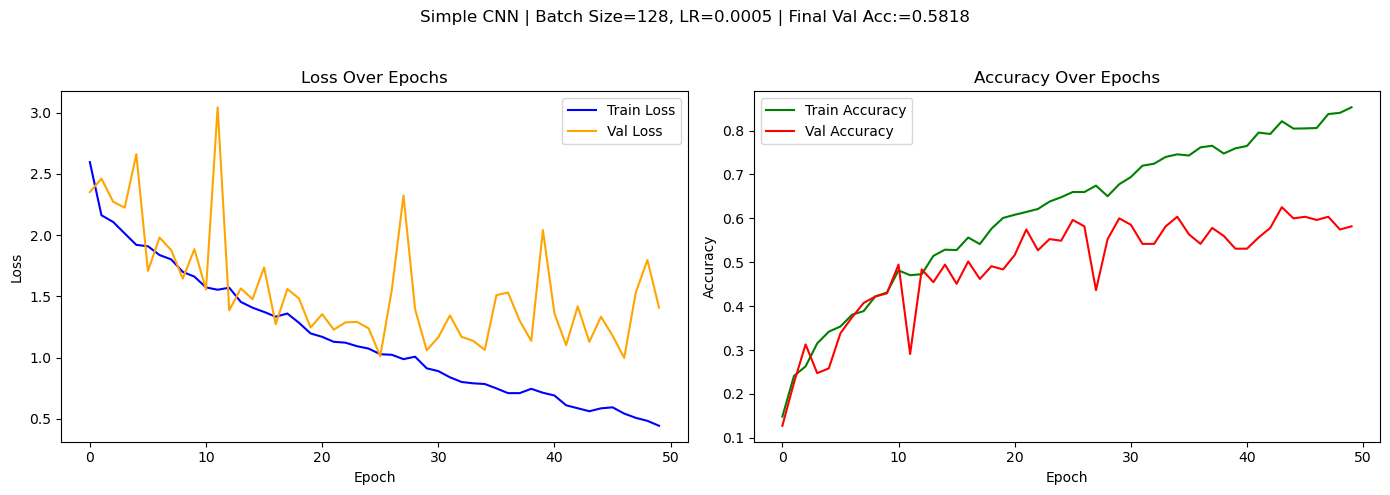


Training with batch size = 128, learning rate = 0.0001
Epoch [1/50] - Train Acc: 0.1686 - Val Acc: 0.1055
Epoch [2/50] - Train Acc: 0.2750 - Val Acc: 0.1200
Epoch [3/50] - Train Acc: 0.3209 - Val Acc: 0.2873
Epoch [4/50] - Train Acc: 0.3518 - Val Acc: 0.4073
Epoch [5/50] - Train Acc: 0.3900 - Val Acc: 0.3782
Epoch [6/50] - Train Acc: 0.4127 - Val Acc: 0.4036
Epoch [7/50] - Train Acc: 0.4418 - Val Acc: 0.4655
Epoch [8/50] - Train Acc: 0.4645 - Val Acc: 0.4218
Epoch [9/50] - Train Acc: 0.4627 - Val Acc: 0.3164
Epoch [10/50] - Train Acc: 0.4741 - Val Acc: 0.4873
Epoch [11/50] - Train Acc: 0.4923 - Val Acc: 0.4545
Epoch [12/50] - Train Acc: 0.5177 - Val Acc: 0.5055
Epoch [13/50] - Train Acc: 0.5318 - Val Acc: 0.4145
Epoch [14/50] - Train Acc: 0.5436 - Val Acc: 0.5345
Epoch [15/50] - Train Acc: 0.5409 - Val Acc: 0.3927
Epoch [16/50] - Train Acc: 0.5491 - Val Acc: 0.4945
Epoch [17/50] - Train Acc: 0.5932 - Val Acc: 0.5527
Epoch [18/50] - Train Acc: 0.5855 - Val Acc: 0.5127
Epoch [19/50] - T

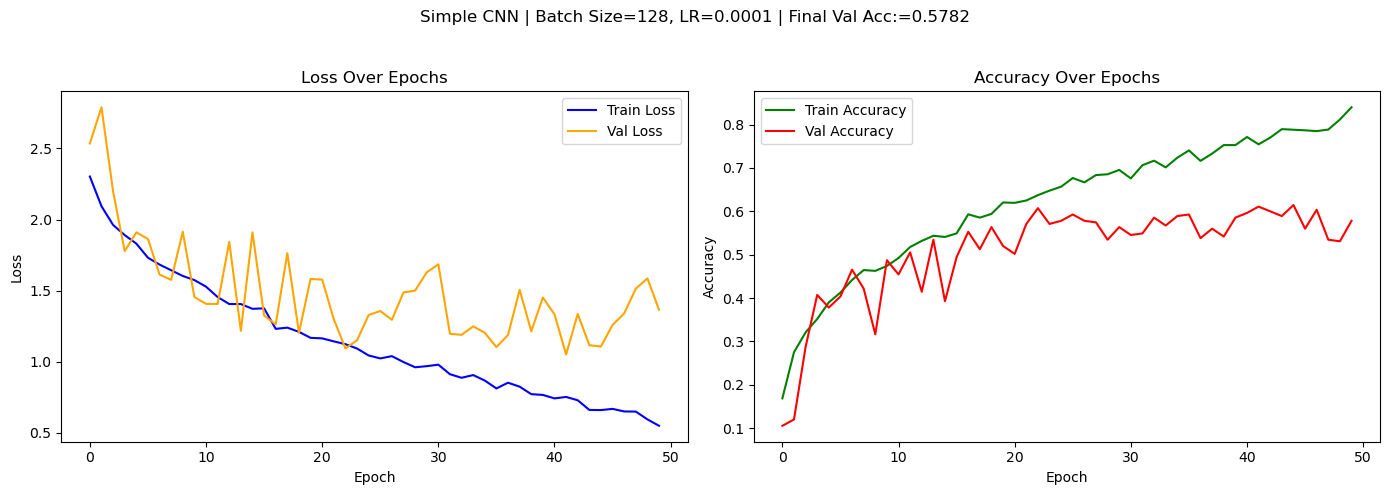

In [64]:
best_model_data_simple_cnn = train_and_evaluate_model(
    model_class=SimpleCNN,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_names=class_names,
    batch_sizes=[64, 128],
    learning_rates=[0.001, 0.0005, 0.0001],
    num_epochs=50,
    device=device,
    title="Simple CNN"
)

In [77]:
test_acc_simple = evaluate_model_on_test(best_model_data_simple_cnn["model"], test_dataset, device)
print(f"Test Accuracy for Best Simple CNN (Batch Size: {best_model_data_simple_cnn["batch_size"]}, Learning Rate: {best_model_data_simple_cnn["learning_rate"]}): ||{test_acc_simple:.4f}||")

Test Accuracy for Best Simple CNN (Batch Size: 64, Learning Rate: 0.0005): ||0.5527||


In [78]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out


class ResidualCNN(nn.Module):
    def __init__(self, num_classes=11, use_dropout=False, dropout_rate=0.5):
        super(ResidualCNN, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 128 → 64
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),  # 64 → 32
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),  # 32 → 16
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16 → 8
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # No pooling
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Fully Connected Layers
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU()
        ]
        if use_dropout:
            classifier_layers.append(nn.Dropout(dropout_rate))
        classifier_layers.append(nn.Linear(512, num_classes))

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x



Training with batch size = 64, learning rate = 0.001
Epoch [1/50] - Train Acc: 0.0923 - Val Acc: 0.0945
Epoch [2/50] - Train Acc: 0.1518 - Val Acc: 0.1818
Epoch [3/50] - Train Acc: 0.1786 - Val Acc: 0.2000
Epoch [4/50] - Train Acc: 0.2036 - Val Acc: 0.2255
Epoch [5/50] - Train Acc: 0.2173 - Val Acc: 0.2291
Epoch [6/50] - Train Acc: 0.2418 - Val Acc: 0.2873
Epoch [7/50] - Train Acc: 0.2668 - Val Acc: 0.2909
Epoch [8/50] - Train Acc: 0.2709 - Val Acc: 0.2545
Epoch [9/50] - Train Acc: 0.2709 - Val Acc: 0.3164
Epoch [10/50] - Train Acc: 0.2918 - Val Acc: 0.3055
Epoch [11/50] - Train Acc: 0.3055 - Val Acc: 0.3164
Epoch [12/50] - Train Acc: 0.3300 - Val Acc: 0.3055
Epoch [13/50] - Train Acc: 0.3086 - Val Acc: 0.3018
Epoch [14/50] - Train Acc: 0.3377 - Val Acc: 0.3527
Epoch [15/50] - Train Acc: 0.3586 - Val Acc: 0.3236
Epoch [16/50] - Train Acc: 0.3559 - Val Acc: 0.3636
Epoch [17/50] - Train Acc: 0.3750 - Val Acc: 0.3600
Epoch [18/50] - Train Acc: 0.3845 - Val Acc: 0.4327
Epoch [19/50] - Tra

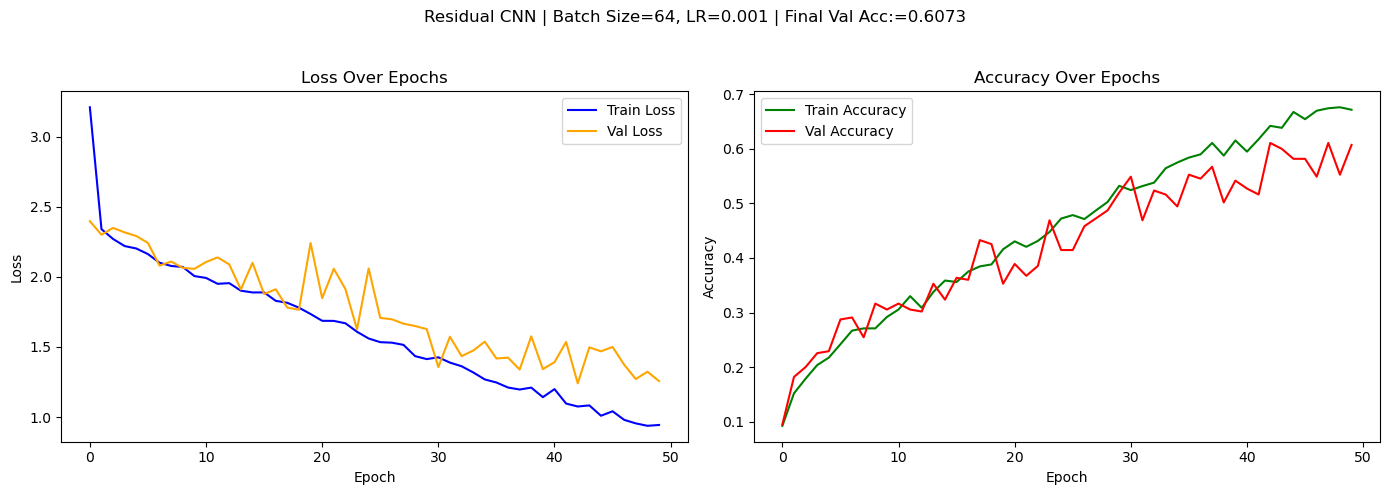


Training with batch size = 64, learning rate = 0.0005
Epoch [1/50] - Train Acc: 0.1455 - Val Acc: 0.1564
Epoch [2/50] - Train Acc: 0.2173 - Val Acc: 0.2691
Epoch [3/50] - Train Acc: 0.2736 - Val Acc: 0.3200
Epoch [4/50] - Train Acc: 0.2982 - Val Acc: 0.3236
Epoch [5/50] - Train Acc: 0.3177 - Val Acc: 0.3273
Epoch [6/50] - Train Acc: 0.3436 - Val Acc: 0.3164
Epoch [7/50] - Train Acc: 0.3591 - Val Acc: 0.3091
Epoch [8/50] - Train Acc: 0.3786 - Val Acc: 0.4255
Epoch [9/50] - Train Acc: 0.4068 - Val Acc: 0.4073
Epoch [10/50] - Train Acc: 0.4227 - Val Acc: 0.4655
Epoch [11/50] - Train Acc: 0.4327 - Val Acc: 0.4800
Epoch [12/50] - Train Acc: 0.4673 - Val Acc: 0.4909
Epoch [13/50] - Train Acc: 0.4614 - Val Acc: 0.4327
Epoch [14/50] - Train Acc: 0.4645 - Val Acc: 0.4073
Epoch [15/50] - Train Acc: 0.4973 - Val Acc: 0.5200
Epoch [16/50] - Train Acc: 0.5141 - Val Acc: 0.5345
Epoch [17/50] - Train Acc: 0.5359 - Val Acc: 0.5236
Epoch [18/50] - Train Acc: 0.5377 - Val Acc: 0.5236
Epoch [19/50] - Tr

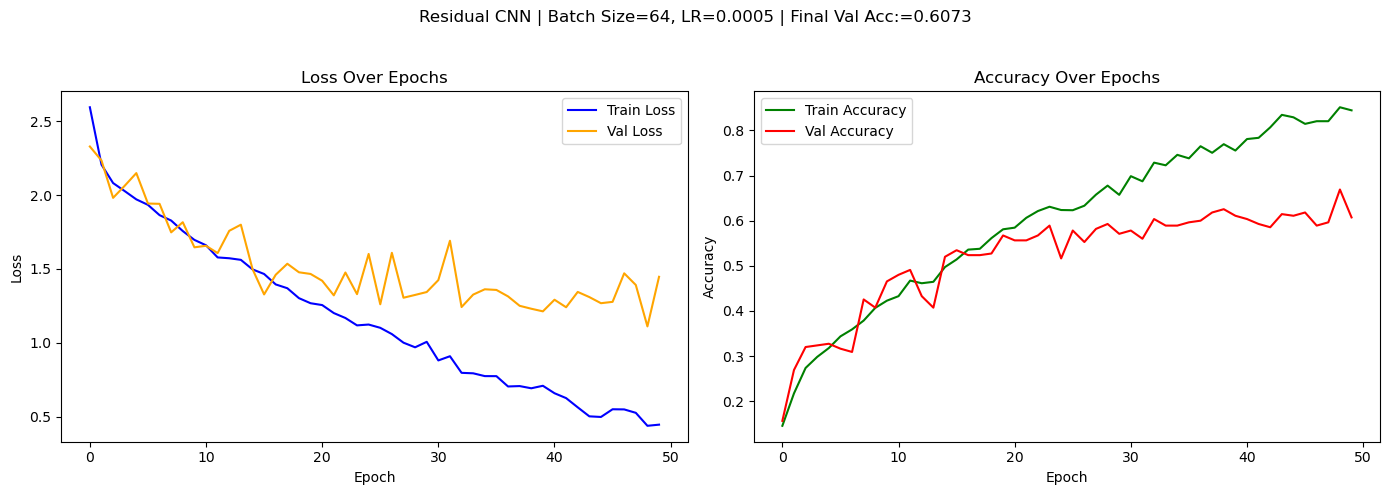


Training with batch size = 64, learning rate = 0.0001
Epoch [1/50] - Train Acc: 0.1723 - Val Acc: 0.1745
Epoch [2/50] - Train Acc: 0.2718 - Val Acc: 0.2873
Epoch [3/50] - Train Acc: 0.3182 - Val Acc: 0.3018
Epoch [4/50] - Train Acc: 0.3482 - Val Acc: 0.3455
Epoch [5/50] - Train Acc: 0.3736 - Val Acc: 0.4400
Epoch [6/50] - Train Acc: 0.3950 - Val Acc: 0.4182
Epoch [7/50] - Train Acc: 0.4041 - Val Acc: 0.4800
Epoch [8/50] - Train Acc: 0.4414 - Val Acc: 0.4436
Epoch [9/50] - Train Acc: 0.4545 - Val Acc: 0.4909
Epoch [10/50] - Train Acc: 0.4918 - Val Acc: 0.4800
Epoch [11/50] - Train Acc: 0.4850 - Val Acc: 0.4836
Epoch [12/50] - Train Acc: 0.4941 - Val Acc: 0.4800
Epoch [13/50] - Train Acc: 0.5418 - Val Acc: 0.5164
Epoch [14/50] - Train Acc: 0.5291 - Val Acc: 0.5200
Epoch [15/50] - Train Acc: 0.5568 - Val Acc: 0.5273
Epoch [16/50] - Train Acc: 0.5709 - Val Acc: 0.5127
Epoch [17/50] - Train Acc: 0.5736 - Val Acc: 0.5382
Epoch [18/50] - Train Acc: 0.5768 - Val Acc: 0.4873
Epoch [19/50] - Tr

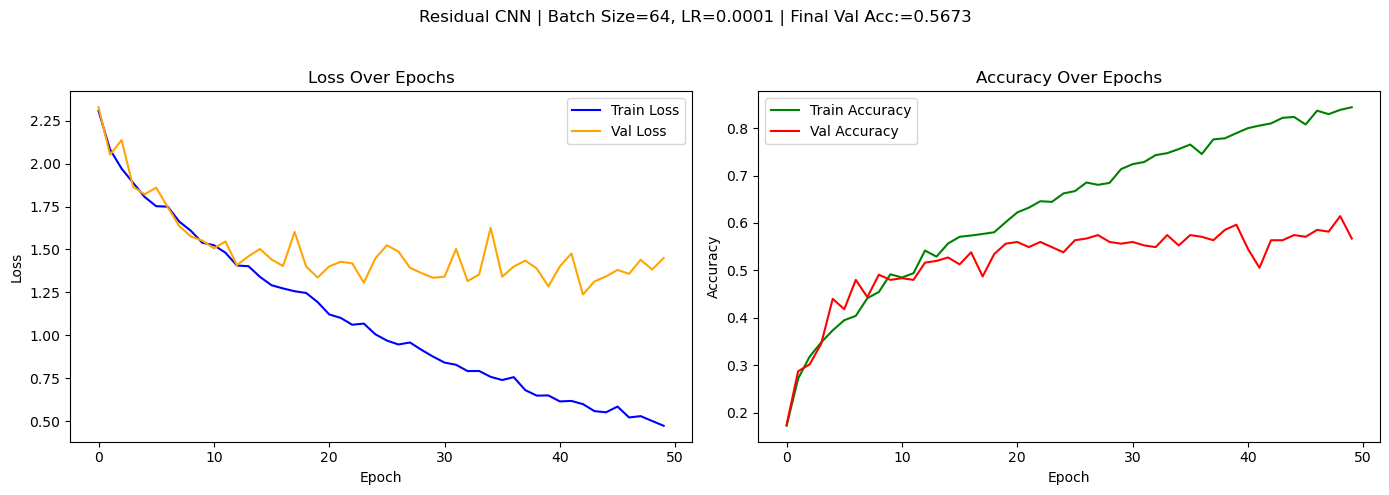


Training with batch size = 128, learning rate = 0.001
Epoch [1/50] - Train Acc: 0.0991 - Val Acc: 0.1018
Epoch [2/50] - Train Acc: 0.1177 - Val Acc: 0.1345
Epoch [3/50] - Train Acc: 0.1423 - Val Acc: 0.1491
Epoch [4/50] - Train Acc: 0.1664 - Val Acc: 0.2400
Epoch [5/50] - Train Acc: 0.1959 - Val Acc: 0.2182
Epoch [6/50] - Train Acc: 0.2159 - Val Acc: 0.2145
Epoch [7/50] - Train Acc: 0.2205 - Val Acc: 0.1818
Epoch [8/50] - Train Acc: 0.2214 - Val Acc: 0.2727
Epoch [9/50] - Train Acc: 0.2391 - Val Acc: 0.2691
Epoch [10/50] - Train Acc: 0.2505 - Val Acc: 0.1600
Epoch [11/50] - Train Acc: 0.2686 - Val Acc: 0.2691
Epoch [12/50] - Train Acc: 0.2682 - Val Acc: 0.2691
Epoch [13/50] - Train Acc: 0.2850 - Val Acc: 0.3491
Epoch [14/50] - Train Acc: 0.3114 - Val Acc: 0.3200
Epoch [15/50] - Train Acc: 0.3327 - Val Acc: 0.3818
Epoch [16/50] - Train Acc: 0.3282 - Val Acc: 0.2836
Epoch [17/50] - Train Acc: 0.3473 - Val Acc: 0.3709
Epoch [18/50] - Train Acc: 0.3373 - Val Acc: 0.3636
Epoch [19/50] - Tr

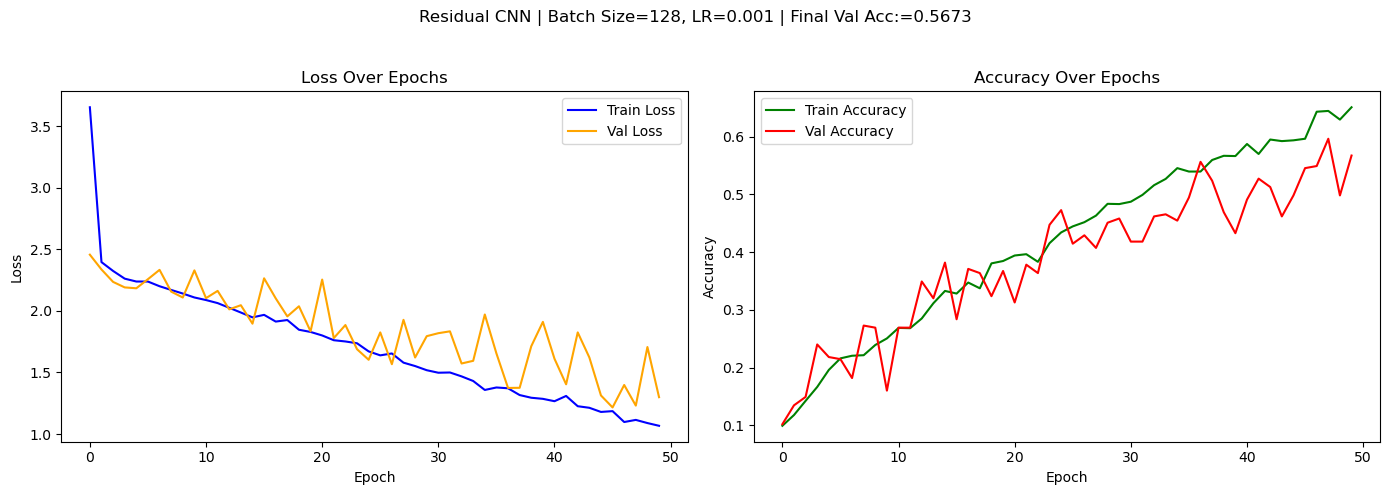


Training with batch size = 128, learning rate = 0.0005
Epoch [1/50] - Train Acc: 0.1373 - Val Acc: 0.1200
Epoch [2/50] - Train Acc: 0.1905 - Val Acc: 0.1273
Epoch [3/50] - Train Acc: 0.2145 - Val Acc: 0.1745
Epoch [4/50] - Train Acc: 0.2595 - Val Acc: 0.3200
Epoch [5/50] - Train Acc: 0.3032 - Val Acc: 0.2945
Epoch [6/50] - Train Acc: 0.3014 - Val Acc: 0.3455
Epoch [7/50] - Train Acc: 0.3164 - Val Acc: 0.3200
Epoch [8/50] - Train Acc: 0.3536 - Val Acc: 0.3600
Epoch [9/50] - Train Acc: 0.3577 - Val Acc: 0.3818
Epoch [10/50] - Train Acc: 0.4050 - Val Acc: 0.4255
Epoch [11/50] - Train Acc: 0.4077 - Val Acc: 0.4509
Epoch [12/50] - Train Acc: 0.4173 - Val Acc: 0.4436
Epoch [13/50] - Train Acc: 0.4273 - Val Acc: 0.3818
Epoch [14/50] - Train Acc: 0.4577 - Val Acc: 0.4582
Epoch [15/50] - Train Acc: 0.4641 - Val Acc: 0.4655
Epoch [16/50] - Train Acc: 0.4827 - Val Acc: 0.4800
Epoch [17/50] - Train Acc: 0.5082 - Val Acc: 0.5164
Epoch [18/50] - Train Acc: 0.5145 - Val Acc: 0.5600
Epoch [19/50] - T

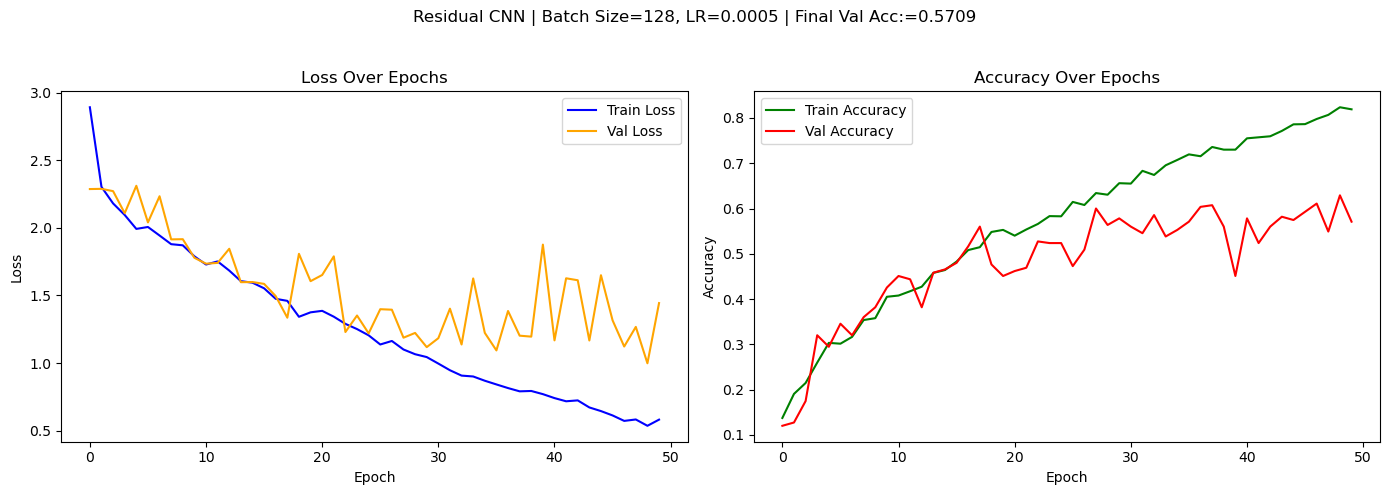


Training with batch size = 128, learning rate = 0.0001
Epoch [1/50] - Train Acc: 0.1473 - Val Acc: 0.1164
Epoch [2/50] - Train Acc: 0.2500 - Val Acc: 0.2036
Epoch [3/50] - Train Acc: 0.2845 - Val Acc: 0.2727
Epoch [4/50] - Train Acc: 0.3132 - Val Acc: 0.3345
Epoch [5/50] - Train Acc: 0.3518 - Val Acc: 0.3600
Epoch [6/50] - Train Acc: 0.3673 - Val Acc: 0.4109
Epoch [7/50] - Train Acc: 0.3805 - Val Acc: 0.4291
Epoch [8/50] - Train Acc: 0.4023 - Val Acc: 0.4145
Epoch [9/50] - Train Acc: 0.4109 - Val Acc: 0.4000
Epoch [10/50] - Train Acc: 0.4405 - Val Acc: 0.4582
Epoch [11/50] - Train Acc: 0.4586 - Val Acc: 0.4582
Epoch [12/50] - Train Acc: 0.4736 - Val Acc: 0.4145
Epoch [13/50] - Train Acc: 0.4732 - Val Acc: 0.4436
Epoch [14/50] - Train Acc: 0.4895 - Val Acc: 0.4982
Epoch [15/50] - Train Acc: 0.4927 - Val Acc: 0.4909
Epoch [16/50] - Train Acc: 0.5141 - Val Acc: 0.4836
Epoch [17/50] - Train Acc: 0.5245 - Val Acc: 0.4727
Epoch [18/50] - Train Acc: 0.5364 - Val Acc: 0.4836
Epoch [19/50] - T

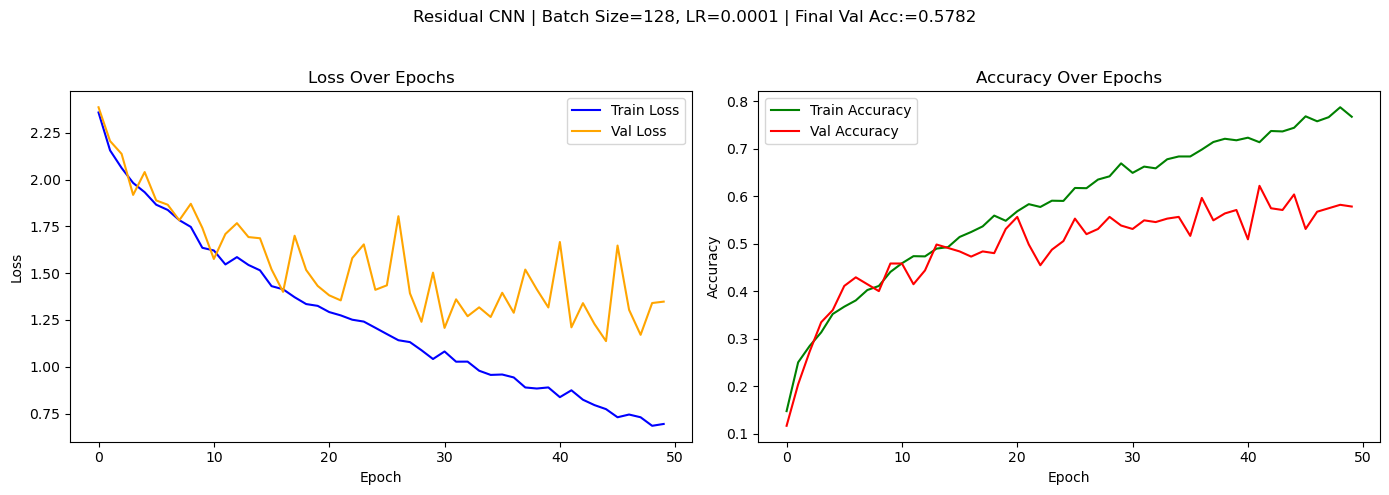

In [79]:
best_model_data_residual_cnn = train_and_evaluate_model(
    model_class=ResidualCNN,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_names=class_names,
    batch_sizes=[64, 128],
    learning_rates=[0.001, 0.0005, 0.0001],
    num_epochs=50,
    device=device,
    title="Residual CNN"
)

In [81]:
test_acc_residual = evaluate_model_on_test(best_model_data_residual_cnn["model"], test_dataset, device)
print(f"Test Accuracy for Residual CNN (Batch Size: {best_model_data_residual_cnn["batch_size"]}, Learning Rate: {best_model_data_residual_cnn["learning_rate"]}): {test_acc_residual:.4f}")

Test Accuracy for Residual CNN (Batch Size: 64, Learning Rate: 0.001): 0.5018



Training with dropout = 0.3
Epoch [1/50] - Train Acc: 0.1445 - Val Acc: 0.1055
Epoch [2/50] - Train Acc: 0.1923 - Val Acc: 0.2436
Epoch [3/50] - Train Acc: 0.2318 - Val Acc: 0.2473
Epoch [4/50] - Train Acc: 0.2559 - Val Acc: 0.2691
Epoch [5/50] - Train Acc: 0.2818 - Val Acc: 0.2000
Epoch [6/50] - Train Acc: 0.2741 - Val Acc: 0.3382
Epoch [7/50] - Train Acc: 0.2959 - Val Acc: 0.3236
Epoch [8/50] - Train Acc: 0.3164 - Val Acc: 0.3309
Epoch [9/50] - Train Acc: 0.3250 - Val Acc: 0.3673
Epoch [10/50] - Train Acc: 0.3395 - Val Acc: 0.3200
Epoch [11/50] - Train Acc: 0.3582 - Val Acc: 0.3709
Epoch [12/50] - Train Acc: 0.3709 - Val Acc: 0.3564
Epoch [13/50] - Train Acc: 0.3818 - Val Acc: 0.3782
Epoch [14/50] - Train Acc: 0.3941 - Val Acc: 0.3818
Epoch [15/50] - Train Acc: 0.4159 - Val Acc: 0.4509
Epoch [16/50] - Train Acc: 0.4318 - Val Acc: 0.4145
Epoch [17/50] - Train Acc: 0.4168 - Val Acc: 0.4582
Epoch [18/50] - Train Acc: 0.4250 - Val Acc: 0.4655
Epoch [19/50] - Train Acc: 0.4523 - Val Acc:

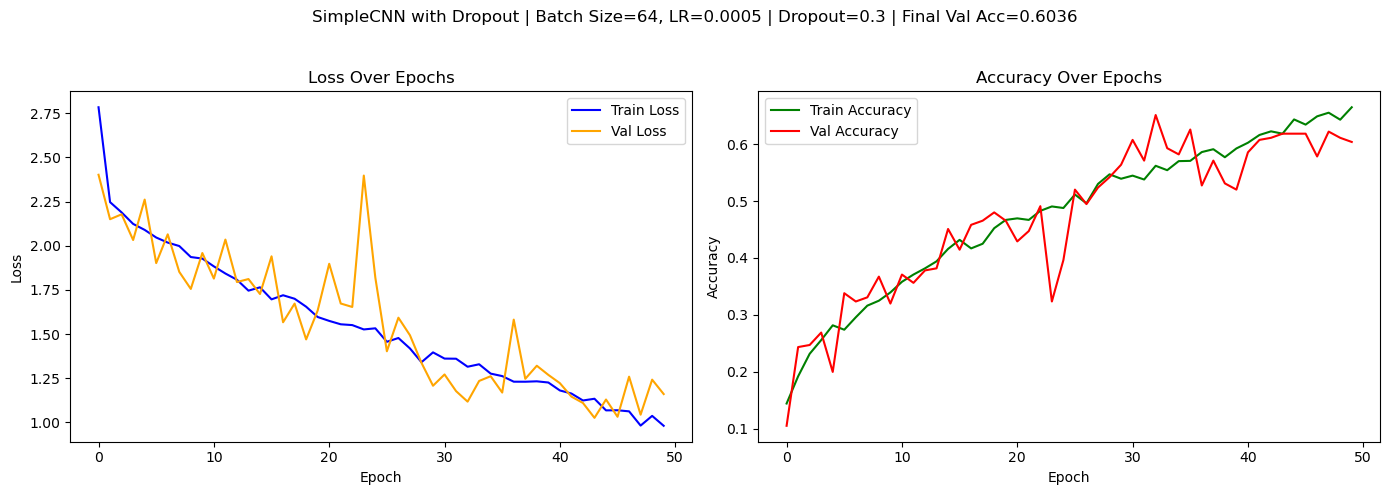


Training with dropout = 0.5
Epoch [1/50] - Train Acc: 0.1168 - Val Acc: 0.1927
Epoch [2/50] - Train Acc: 0.1741 - Val Acc: 0.2727
Epoch [3/50] - Train Acc: 0.2059 - Val Acc: 0.2618
Epoch [4/50] - Train Acc: 0.2173 - Val Acc: 0.1855
Epoch [5/50] - Train Acc: 0.2327 - Val Acc: 0.2436
Epoch [6/50] - Train Acc: 0.2464 - Val Acc: 0.2655
Epoch [7/50] - Train Acc: 0.2564 - Val Acc: 0.3018
Epoch [8/50] - Train Acc: 0.2595 - Val Acc: 0.3055
Epoch [9/50] - Train Acc: 0.2650 - Val Acc: 0.2800
Epoch [10/50] - Train Acc: 0.2741 - Val Acc: 0.3418
Epoch [11/50] - Train Acc: 0.2900 - Val Acc: 0.3091
Epoch [12/50] - Train Acc: 0.2836 - Val Acc: 0.3455
Epoch [13/50] - Train Acc: 0.3159 - Val Acc: 0.4109
Epoch [14/50] - Train Acc: 0.3032 - Val Acc: 0.3491
Epoch [15/50] - Train Acc: 0.3105 - Val Acc: 0.4364
Epoch [16/50] - Train Acc: 0.3091 - Val Acc: 0.3818
Epoch [17/50] - Train Acc: 0.3182 - Val Acc: 0.4255
Epoch [18/50] - Train Acc: 0.3082 - Val Acc: 0.3782
Epoch [19/50] - Train Acc: 0.3077 - Val Acc:

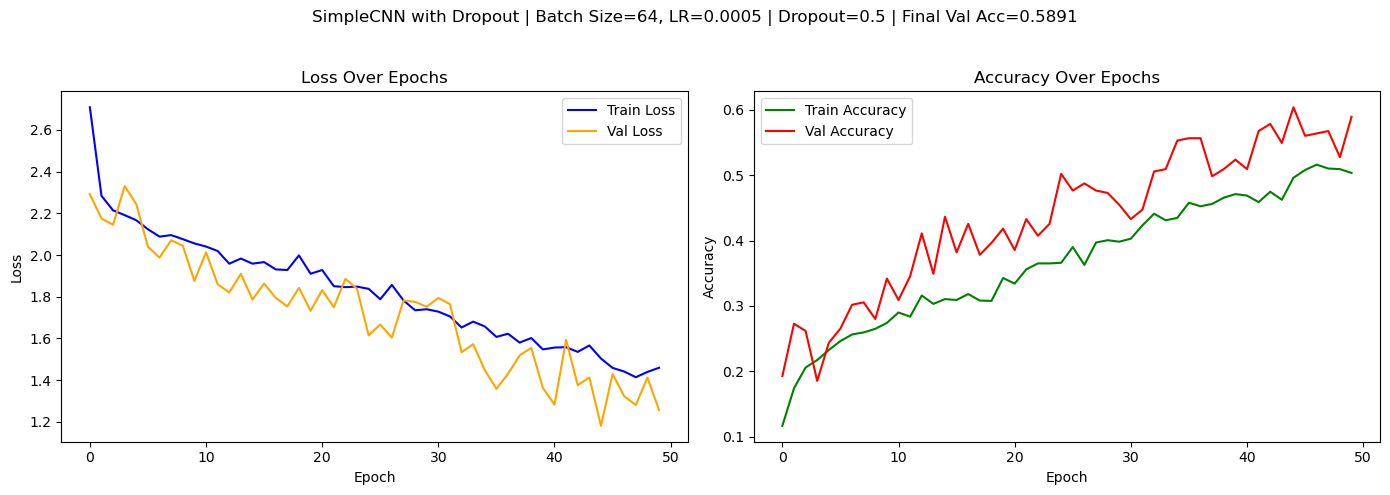

In [82]:
best_dropout_simple_cnn = train_and_evaluate_model_with_dropout(
    model_class=SimpleCNN,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_names=class_names,
    batch_size=best_model_data_simple_cnn["batch_size"],
    learning_rate=best_model_data_simple_cnn["learning_rate"],
    num_epochs=50,
    device=device,
    dropout_values=[0.3, 0.5],
    title="SimpleCNN with Dropout"
)

In [83]:
test_acc_simple_dropout = evaluate_model_on_test(best_dropout_simple_cnn["model"], test_dataset, device)
print(f"Test Accuracy for Best Simple CNN with Dropout (Dropout: {best_dropout_simple_cnn["dropout_rate"]}, Batch Size: {best_dropout_simple_cnn["batch_size"]}, Learning Rate: {best_dropout_simple_cnn["learning_rate"]}): {test_acc_simple_dropout:.4f}")

Test Accuracy for Best Simple CNN with Dropout (Dropout: 0.3, Batch Size: 64, Learning Rate: 0.0005): 0.4909


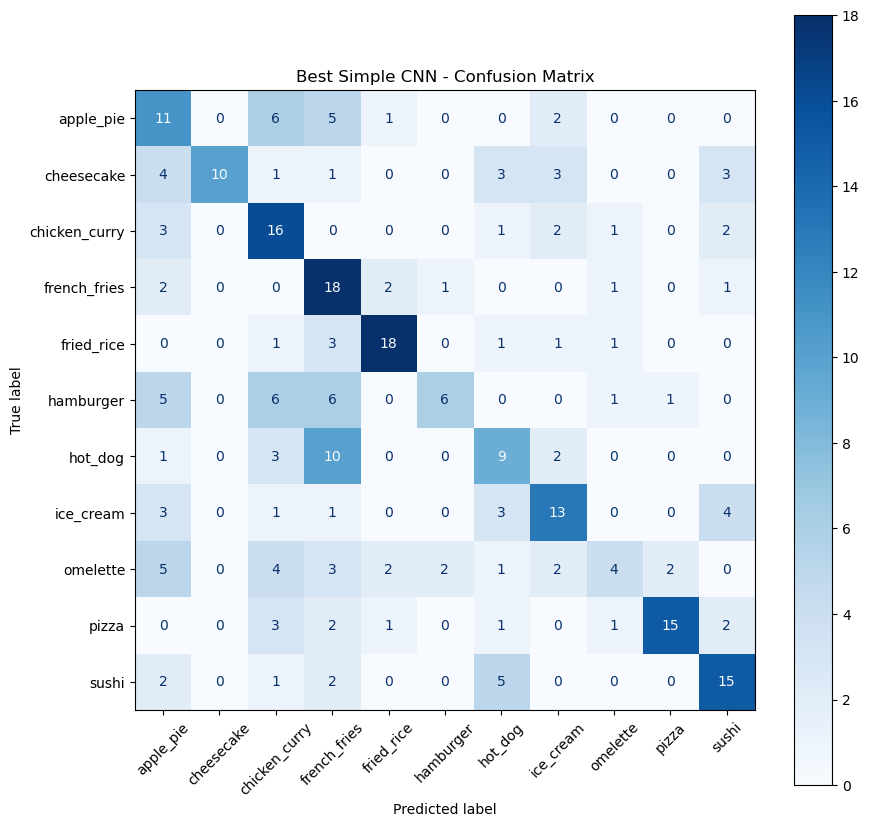

In [84]:
plot_confusion_matrix(best_dropout_simple_cnn, test_dataset, class_names, device, title="Best Simple CNN - Confusion Matrix")


Training with dropout = 0.3
Epoch [1/50] - Train Acc: 0.1009 - Val Acc: 0.1055
Epoch [2/50] - Train Acc: 0.1118 - Val Acc: 0.1018
Epoch [3/50] - Train Acc: 0.1223 - Val Acc: 0.1164
Epoch [4/50] - Train Acc: 0.1127 - Val Acc: 0.1164
Epoch [5/50] - Train Acc: 0.1245 - Val Acc: 0.1236
Epoch [6/50] - Train Acc: 0.1536 - Val Acc: 0.1636
Epoch [7/50] - Train Acc: 0.1695 - Val Acc: 0.1636
Epoch [8/50] - Train Acc: 0.1841 - Val Acc: 0.2000
Epoch [9/50] - Train Acc: 0.1705 - Val Acc: 0.2182
Epoch [10/50] - Train Acc: 0.1877 - Val Acc: 0.2364
Epoch [11/50] - Train Acc: 0.1950 - Val Acc: 0.2182
Epoch [12/50] - Train Acc: 0.1773 - Val Acc: 0.2436
Epoch [13/50] - Train Acc: 0.1909 - Val Acc: 0.2255
Epoch [14/50] - Train Acc: 0.2095 - Val Acc: 0.2218
Epoch [15/50] - Train Acc: 0.2082 - Val Acc: 0.2145
Epoch [16/50] - Train Acc: 0.2164 - Val Acc: 0.2764
Epoch [17/50] - Train Acc: 0.2259 - Val Acc: 0.2582
Epoch [18/50] - Train Acc: 0.2255 - Val Acc: 0.2800
Epoch [19/50] - Train Acc: 0.2323 - Val Acc:

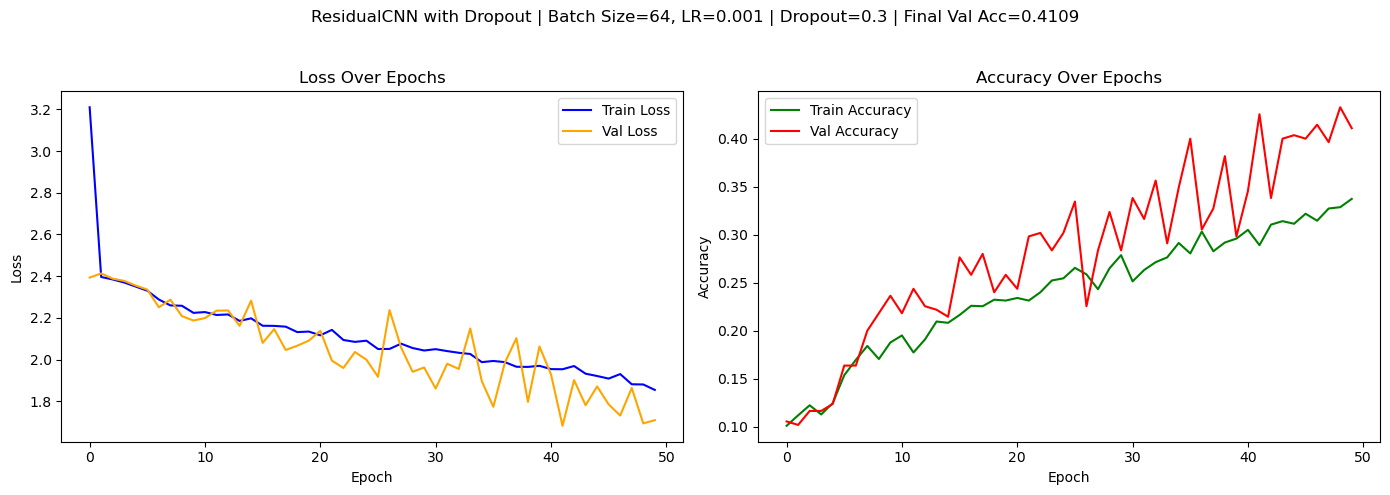


Training with dropout = 0.5
Epoch [1/50] - Train Acc: 0.0964 - Val Acc: 0.0836
Epoch [2/50] - Train Acc: 0.1009 - Val Acc: 0.0909
Epoch [3/50] - Train Acc: 0.0977 - Val Acc: 0.0945
Epoch [4/50] - Train Acc: 0.1018 - Val Acc: 0.1236
Epoch [5/50] - Train Acc: 0.1123 - Val Acc: 0.1382
Epoch [6/50] - Train Acc: 0.1118 - Val Acc: 0.1345
Epoch [7/50] - Train Acc: 0.1245 - Val Acc: 0.1745
Epoch [8/50] - Train Acc: 0.1245 - Val Acc: 0.1673
Epoch [9/50] - Train Acc: 0.1232 - Val Acc: 0.1564
Epoch [10/50] - Train Acc: 0.1355 - Val Acc: 0.1309
Epoch [11/50] - Train Acc: 0.1441 - Val Acc: 0.1600
Epoch [12/50] - Train Acc: 0.1368 - Val Acc: 0.1927
Epoch [13/50] - Train Acc: 0.1409 - Val Acc: 0.1309
Epoch [14/50] - Train Acc: 0.1368 - Val Acc: 0.1709
Epoch [15/50] - Train Acc: 0.1323 - Val Acc: 0.1636
Epoch [16/50] - Train Acc: 0.1273 - Val Acc: 0.1600
Epoch [17/50] - Train Acc: 0.1305 - Val Acc: 0.1855
Epoch [18/50] - Train Acc: 0.1482 - Val Acc: 0.2036
Epoch [19/50] - Train Acc: 0.1386 - Val Acc:

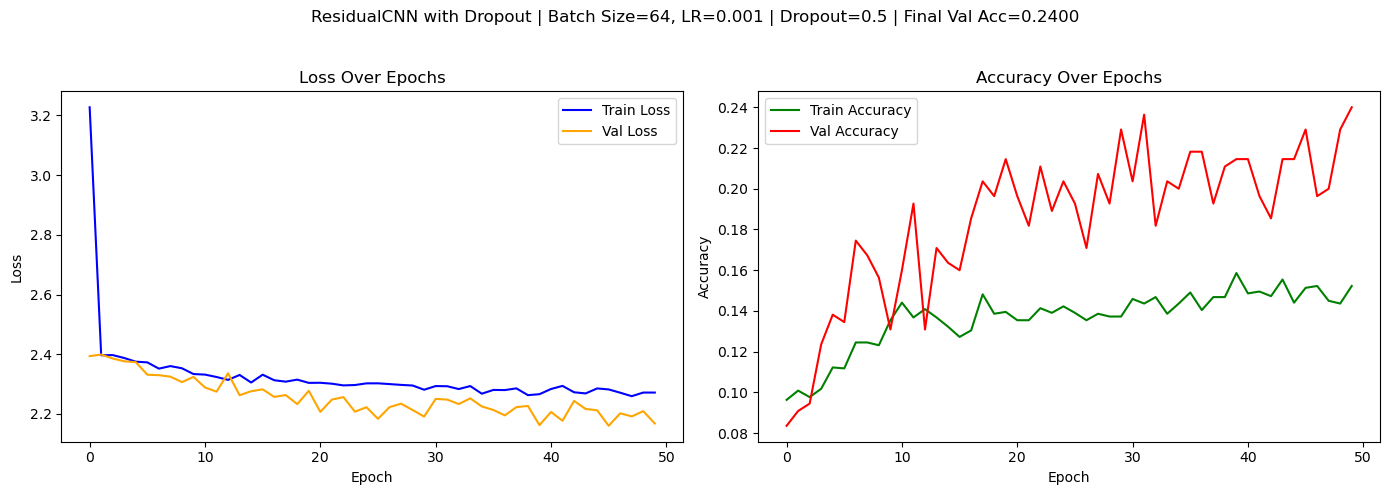

In [85]:
best_dropout_residual_cnn = train_and_evaluate_model_with_dropout(
    model_class=ResidualCNN,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_names=class_names,
    batch_size=best_model_data_residual_cnn["batch_size"],
    learning_rate=best_model_data_residual_cnn["learning_rate"],
    num_epochs=50,
    device=device,
    dropout_values=[0.3, 0.5],
    title="ResidualCNN with Dropout"
)

In [86]:
test_acc_residual_dropout = evaluate_model_on_test(best_dropout_residual_cnn["model"], test_dataset, device)
print(f"Test Accuracy for Best Residual CNN with Dropout (Dropout: {best_dropout_residual_cnn["dropout_rate"]}, Batch Size: {best_dropout_residual_cnn["batch_size"]}, Learning Rate: {best_dropout_residual_cnn["learning_rate"]}): {test_acc_residual_dropout:.4f}")

Test Accuracy for Best Residual CNN with Dropout (Dropout: 0.3, Batch Size: 64, Learning Rate: 0.001): 0.3782


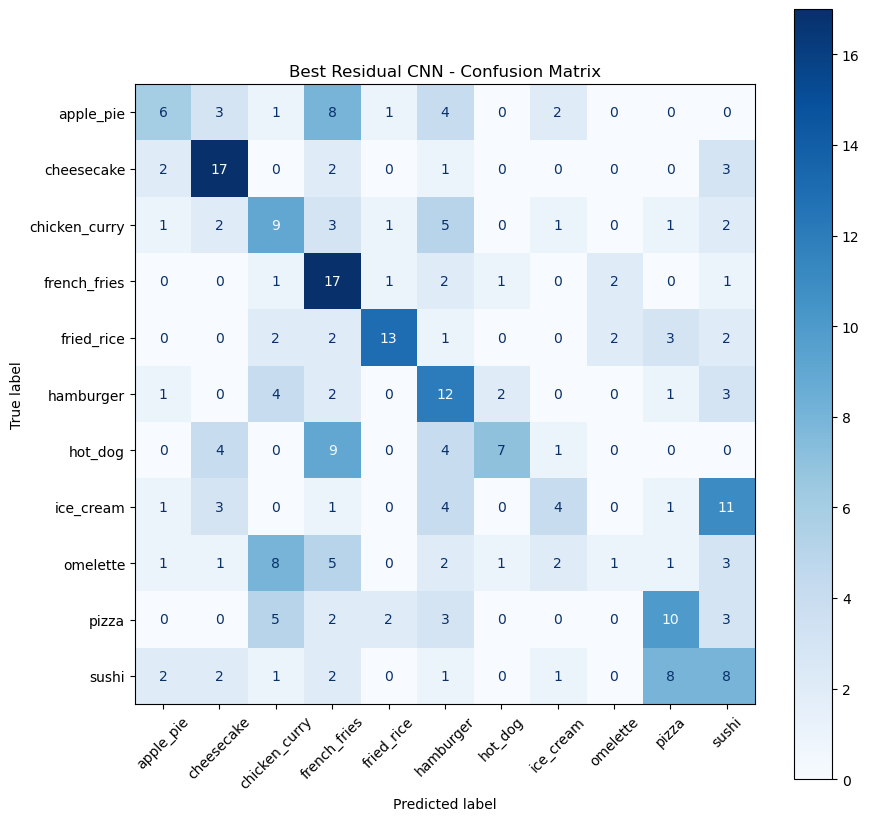

In [87]:
plot_confusion_matrix(best_dropout_residual_cnn, test_dataset, class_names, device, title="Best Residual CNN - Confusion Matrix")

## PART 2 - Transfer Learning with CNNs

In [1]:
def train_mobilenetv3_transfer(train_dataset, val_dataset, test_dataset, class_names,
                                mode='fc_only',  # or 'last_two_blocks'
                                batch_size=64,
                                learning_rate=0.001,
                                num_epochs=20,
                                device='cuda'):
    
    # Load pre-trained MobileNetV3
    model = models.mobilenet_v3_large(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Enable training for FC layer
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(class_names))

    # Optionally unfreeze last two conv blocks
    if mode == 'last_two_blocks':
        for layer in list(model.features.children())[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

    model = model.to(device)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(trainable_params, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_model = None

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"[{mode.upper()}] Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"MobileNetV3 ({mode}) | BS={batch_size}, LR={learning_rate} | Final Val Acc={val_accuracies[-1]:.4f}")

    axs[0].plot(train_losses, label="Train Loss", color='blue')
    axs[0].set_title("Training Loss Over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(val_accuracies, label="Validation Accuracy", color='red')
    axs[1].set_title("Validation Accuracy Over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    model.eval()
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_acc = test_correct / test_total
    print(f"[{mode.upper()}] Final Test Accuracy: {test_acc:.4f}")

    return {
        "model": model,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_accuracy": best_val_acc,
        "test_accuracy": test_acc,
        "y_true": y_true,
        "y_pred": y_pred
    }

In [2]:
def plot_confusion_matrix_from_results(results, class_names, title="Confusion Matrix"):
    y_true = results["y_true"]
    y_pred = results["y_pred"]
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    ax.set_title(title)
    plt.show()

c:\Users\Kayra\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kayra\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[FC_ONLY] Epoch [1/30] | Train Acc: 0.3114 | Val Acc: 0.6436
[FC_ONLY] Epoch [2/30] | Train Acc: 0.5550 | Val Acc: 0.7236
[FC_ONLY] Epoch [3/30] | Train Acc: 0.6045 | Val Acc: 0.7455
[FC_ONLY] Epoch [4/30] | Train Acc: 0.6282 | Val Acc: 0.7564
[FC_ONLY] Epoch [5/30] | Train Acc: 0.6459 | Val Acc: 0.7564
[FC_ONLY] Epoch [6/30] | Train Acc: 0.6527 | Val Acc: 0.7600
[FC_ONLY] Epoch [7/30] | Train Acc: 0.6482 | Val Acc: 0.7673
[FC_ONLY] Epoch [8/30] | Train Acc: 0.6764 | Val Acc: 0.7418
[FC_ONLY] Epoch [9/30] | Train Acc: 0.6755 | Val Acc: 0.7309
[FC_ONLY] Epoch [10/30] | Train Acc: 0.6764 | Val Acc: 0.7200
[FC_ONLY] Epoch [11/30] | Train Acc: 0.6982 | Val Acc: 0.7164
[FC_ONLY] Epoch [12/30] | Train Acc: 0.6941 | Val Acc: 0.7018
[FC_ONLY] Epoch [13/30] | Train Acc: 0.6836 | Val Acc: 0.6982
[FC_ONLY] Epoch [14/30] | Train Acc: 0.6905 | Val Acc: 0.7055
[FC_ONLY] Epoch [15/30] | Train Acc: 0.7014 | Val Acc: 0.7091
[FC_ONLY] Epoch [16/30] | Train Acc: 0.7086 | Val Acc: 0.7200
[FC_ONLY] Epoch [

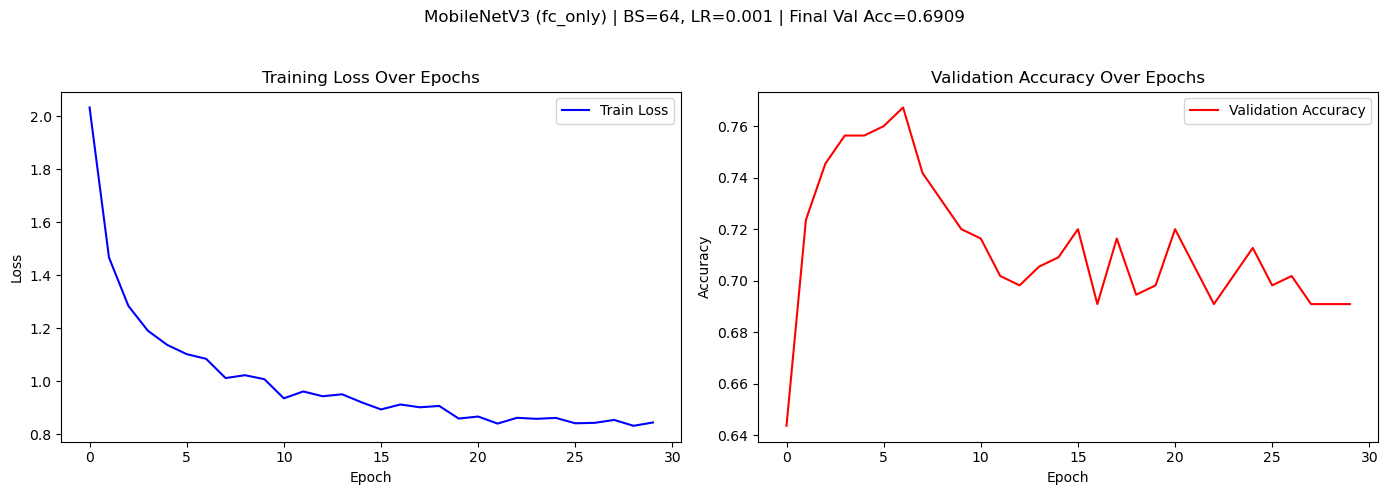

[FC_ONLY] Final Test Accuracy: 0.6182


In [7]:
results_fc_only = train_mobilenetv3_transfer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    class_names=class_names,
    mode='fc_only',
    batch_size=64,
    learning_rate=0.001,
    num_epochs=30,
    device=device
)

[LAST_TWO_BLOCKS] Epoch [1/30] | Train Acc: 0.4532 | Val Acc: 0.7418
[LAST_TWO_BLOCKS] Epoch [2/30] | Train Acc: 0.6914 | Val Acc: 0.7709
[LAST_TWO_BLOCKS] Epoch [3/30] | Train Acc: 0.7668 | Val Acc: 0.7600
[LAST_TWO_BLOCKS] Epoch [4/30] | Train Acc: 0.8186 | Val Acc: 0.8000
[LAST_TWO_BLOCKS] Epoch [5/30] | Train Acc: 0.8495 | Val Acc: 0.7927
[LAST_TWO_BLOCKS] Epoch [6/30] | Train Acc: 0.8845 | Val Acc: 0.7891
[LAST_TWO_BLOCKS] Epoch [7/30] | Train Acc: 0.9136 | Val Acc: 0.8073
[LAST_TWO_BLOCKS] Epoch [8/30] | Train Acc: 0.9309 | Val Acc: 0.7636
[LAST_TWO_BLOCKS] Epoch [9/30] | Train Acc: 0.9268 | Val Acc: 0.7527
[LAST_TWO_BLOCKS] Epoch [10/30] | Train Acc: 0.9350 | Val Acc: 0.7855
[LAST_TWO_BLOCKS] Epoch [11/30] | Train Acc: 0.9482 | Val Acc: 0.7673
[LAST_TWO_BLOCKS] Epoch [12/30] | Train Acc: 0.9495 | Val Acc: 0.7636
[LAST_TWO_BLOCKS] Epoch [13/30] | Train Acc: 0.9609 | Val Acc: 0.7709
[LAST_TWO_BLOCKS] Epoch [14/30] | Train Acc: 0.9591 | Val Acc: 0.7855
[LAST_TWO_BLOCKS] Epoch [15/3

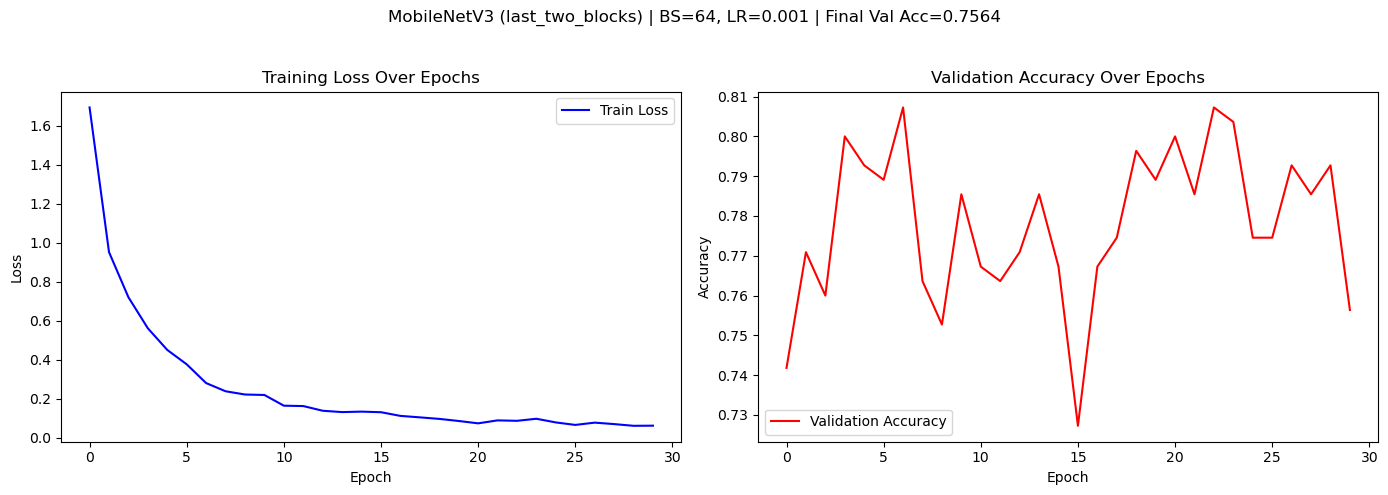

[LAST_TWO_BLOCKS] Final Test Accuracy: 0.6545


In [8]:
results_last_two = train_mobilenetv3_transfer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    class_names=class_names,
    mode='last_two_blocks',
    batch_size=64,
    learning_rate=0.001,
    num_epochs=30,
    device=device
)

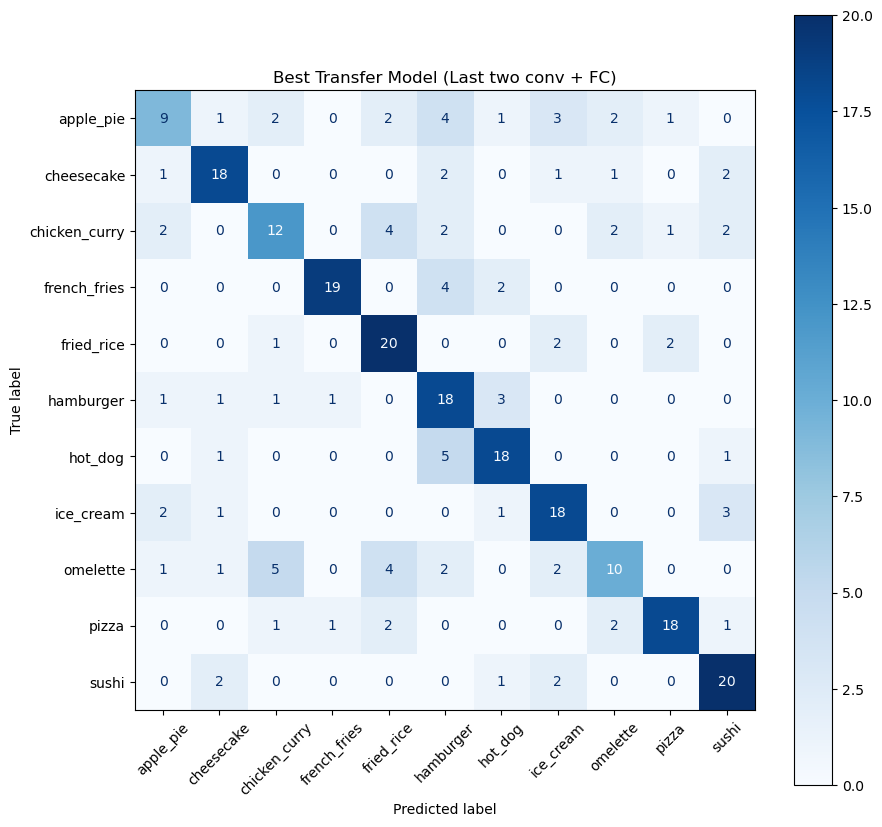

In [9]:
best_results = results_fc_only if results_fc_only["test_accuracy"] > results_last_two["test_accuracy"] else results_last_two
mode = "FC only" if best_results == results_fc_only else "Last two conv + FC"

plot_confusion_matrix_from_results(best_results, class_names, title=f"Best Transfer Model ({mode})")
